In [2]:
!pip install tensorflow keras pillow numpy

In [1]:
mkdir -p Data/{test/image,test/mask,train/image,train/mask}

In [ ]:
import os
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    up3 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv2))
    merge3 = concatenate([conv1, up3], axis=3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(merge3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv3)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def load_data(data_dir, mode="train"):
    image_dir = os.path.join(data_dir, mode, "image")
    mask_dir = os.path.join(data_dir, mode, "mask")

    images = []
    masks = []

    for filename in sorted(os.listdir(image_dir)):
        img = load_img(os.path.join(image_dir, filename), color_mode="grayscale")
        mask = load_img(os.path.join(mask_dir, filename), color_mode="grayscale")

        img = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0

        img = resize(img, [256, 256])
        mask = resize(mask, [256, 256])

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


# Parameters
input_shape = (256, 256, 1)
batch_size = 16
epochs = 50
learning_rate = 1e-4
data_dir = 'Data'

# Load data
x_train, y_train = load_data(data_dir, mode='train')
x_test, y_test = load_data(data_dir, mode='test')

# Build model
model = build_unet(input_shape)
model.compile(optimizer=Adam(learning_rate), loss=binary_crossentropy, metrics=['accuracy'])

# Train model
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

# Save model
model.save('retina_model_2_layer.h5')


Epoch 1/50
5/5 [==============================] - 5s 489ms/step - loss: 0.6834 - accuracy: 0.6794 - val_loss: 0.6643 - val_accuracy: 0.8384
Epoch 2/50
5/5 [==============================] - 2s 443ms/step - loss: 0.6487 - accuracy: 0.8387 - val_loss: 0.6241 - val_accuracy: 0.8384
Epoch 3/50
5/5 [==============================] - 2s 442ms/step - loss: 0.6034 - accuracy: 0.8387 - val_loss: 0.5698 - val_accuracy: 0.8384
Epoch 4/50
5/5 [==============================] - 2s 446ms/step - loss: 0.5416 - accuracy: 0.8387 - val_loss: 0.4988 - val_accuracy: 0.8384
Epoch 5/50
5/5 [==============================] - 2s 451ms/step - loss: 0.4703 - accuracy: 0.8387 - val_loss: 0.4431 - val_accuracy: 0.8384
Epoch 6/50
5/5 [==============================] - 2s 452ms/step - loss: 0.4432 - accuracy: 0.8387 - val_loss: 0.4535 - val_accuracy: 0.8384
Epoch 7/50
5/5 [==============================] - 2s 450ms/step - loss: 0.4471 - accuracy: 0.8387 - val_loss: 0.4389 - val_accuracy: 0.8384
Epoch 8/50
5/5 [====

In [ ]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img

# Define paths
original_images_path = 'Data/train/image'
manual_segmented_images_path = 'Data/train/mask'

# Get list of image files
original_images_files = os.listdir(original_images_path)
manual_segmented_images_files = os.listdir(manual_segmented_images_path)

# Initialize lists to store images
original_images = []
manual_segmented_images = []

# Load original images
for image_file in original_images_files:
    image = load_img(os.path.join(original_images_path, image_file), color_mode='grayscale')
    image = img_to_array(image)
    original_images.append(image)

# Load manual segmented images
for image_file in manual_segmented_images_files:
    image = load_img(os.path.join(manual_segmented_images_path, image_file), color_mode='grayscale')
    image = img_to_array(image)
    manual_segmented_images.append(image)

# Convert lists to numpy arrays
original_images = np.array(original_images, dtype='float') / 255
manual_segmented_images = np.array(manual_segmented_images, dtype='float') / 255

# Define the model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(None, None, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(original_images, manual_segmented_images, epochs=50, batch_size=2, shuffle=True)

model.save('retina_model_3_layer.h5')


Epoch 1/50
40/40 [==============================] - 10s 92ms/step - loss: 0.3318 - accuracy: 0.8561
Epoch 2/50
40/40 [==============================] - 4s 91ms/step - loss: 0.2657 - accuracy: 0.8768
Epoch 3/50
40/40 [==============================] - 4s 92ms/step - loss: 0.2649 - accuracy: 0.8768
Epoch 4/50
40/40 [==============================] - 4s 93ms/step - loss: 0.2628 - accuracy: 0.8768
Epoch 5/50
40/40 [==============================] - 4s 93ms/step - loss: 0.2463 - accuracy: 0.8768
Epoch 6/50
40/40 [==============================] - 4s 93ms/step - loss: 0.2142 - accuracy: 0.8807
Epoch 7/50
40/40 [==============================] - 4s 94ms/step - loss: 0.1878 - accuracy: 0.8960
Epoch 8/50
40/40 [==============================] - 4s 94ms/step - loss: 0.1753 - accuracy: 0.8993
Epoch 9/50
40/40 [==============================] - 4s 94ms/step - loss: 0.1601 - accuracy: 0.9033
Epoch 10/50
40/40 [==============================] - 4s 94ms/step - loss: 0.1515 - accuracy: 0.9051
Epoch 11

In [3]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img

# Define paths
original_images_path = 'Data/train/image'
manual_segmented_images_path = 'Data/train/mask'

# Get list of image files
original_images_files = os.listdir(original_images_path)
manual_segmented_images_files = os.listdir(manual_segmented_images_path)

# Initialize lists to store images
original_images = []
manual_segmented_images = []

# Load original images
for image_file in original_images_files:
    image = load_img(os.path.join(original_images_path, image_file), color_mode='grayscale')
    image = img_to_array(image)
    original_images.append(image)

# Load manual segmented images
for image_file in manual_segmented_images_files:
    image = load_img(os.path.join(manual_segmented_images_path, image_file), color_mode='grayscale')
    image = img_to_array(image)
    manual_segmented_images.append(image)

# Convert lists to numpy arrays
original_images = np.array(original_images, dtype='float') / 255
manual_segmented_images = np.array(manual_segmented_images, dtype='float') / 255

# Define the model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(None, None, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(original_images, manual_segmented_images, epochs=50, batch_size=2, shuffle=True)

model.save('retina_model_4_layer.h5')


Epoch 1/50
40/40 [==============================] - 25s 216ms/step - loss: 0.3286 - accuracy: 0.8768
Epoch 2/50
40/40 [==============================] - 9s 217ms/step - loss: 0.2653 - accuracy: 0.8768
Epoch 3/50
40/40 [==============================] - 9s 218ms/step - loss: 0.2648 - accuracy: 0.8768
Epoch 4/50
40/40 [==============================] - 9s 220ms/step - loss: 0.2636 - accuracy: 0.8768
Epoch 5/50
40/40 [==============================] - 9s 222ms/step - loss: 0.2623 - accuracy: 0.8768
Epoch 6/50
40/40 [==============================] - 9s 222ms/step - loss: 0.2624 - accuracy: 0.8768
Epoch 7/50
40/40 [==============================] - 9s 223ms/step - loss: 0.2633 - accuracy: 0.8770
Epoch 8/50
40/40 [==============================] - 9s 223ms/step - loss: 0.2640 - accuracy: 0.8768
Epoch 9/50
40/40 [==============================] - 9s 224ms/step - loss: 0.2627 - accuracy: 0.8768
Epoch 10/50
40/40 [==============================] - 9s 225ms/step - loss: 0.2573 - accuracy: 0.876

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose,concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add
from keras.models import Model

# Define paths
original_images_path = 'Data/train/image'
manual_segmented_images_path = 'Data/train/mask'

# Get list of image files
original_images_files = os.listdir(original_images_path)
manual_segmented_images_files = os.listdir(manual_segmented_images_path)

# Initialize lists to store images
original_images = []
manual_segmented_images = []

# Load original images
for image_file in original_images_files:
    image = load_img(os.path.join(original_images_path, image_file), color_mode='grayscale')
    image = img_to_array(image)
    original_images.append(image)

# Load manual segmented images
for image_file in manual_segmented_images_files:
    image = load_img(os.path.join(manual_segmented_images_path, image_file), color_mode='grayscale')
    image = img_to_array(image)
    manual_segmented_images.append(image)

# Convert lists to numpy arrays
original_images = np.array(original_images, dtype='float') / 255
manual_segmented_images = np.array(manual_segmented_images, dtype='float') / 255

def build_model(input_shape):
    inputs = Input(input_shape)

    # Down
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Middle
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Up
    up5 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)

    up6 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)

    up7 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)

    # Final layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    return Model(inputs=[inputs], outputs=[output])

model = build_model((512, 512, 1))
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(original_images, manual_segmented_images, epochs=50, batch_size=2, shuffle=True)

model.save('retina_model_4_layer_advanced.h5')


Epoch 1/50
40/40 [==============================] - 24s 233ms/step - loss: 0.3453 - accuracy: 0.8764
Epoch 2/50
40/40 [==============================] - 9s 234ms/step - loss: 0.2625 - accuracy: 0.8768
Epoch 3/50
40/40 [==============================] - 10s 238ms/step - loss: 0.2600 - accuracy: 0.8768
Epoch 4/50
40/40 [==============================] - 10s 238ms/step - loss: 0.2573 - accuracy: 0.8768
Epoch 5/50
40/40 [==============================] - 10s 240ms/step - loss: 0.2550 - accuracy: 0.8768
Epoch 6/50
40/40 [==============================] - 10s 241ms/step - loss: 0.2543 - accuracy: 0.8768
Epoch 7/50
40/40 [==============================] - 10s 243ms/step - loss: 0.2491 - accuracy: 0.8768
Epoch 8/50
40/40 [==============================] - 10s 243ms/step - loss: 0.2403 - accuracy: 0.8789
Epoch 9/50
40/40 [==============================] - 10s 244ms/step - loss: 0.2389 - accuracy: 0.8769
Epoch 10/50
40/40 [==============================] - 10s 244ms/step - loss: 0.2175 - accurac

In [14]:
import cv2

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def clahe_equalized(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(image)

def histo_equalized(image):
    return cv2.equalizeHist(image)

def preprocess_image(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply CLAHE equalization
    image = clahe_equalized(image)

    # Apply gamma adjustment
    image = adjust_gamma(image, gamma=1.2)

    # Apply histogram equalization
    image = histo_equalized(image)

    return image

In [15]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img

# Define paths
original_images_path = 'Data/train/image'
manual_segmented_images_path = 'Data/train/mask'

# Get list of image files
original_images_files = os.listdir(original_images_path)
manual_segmented_images_files = os.listdir(manual_segmented_images_path)

# Initialize lists to store images
original_images = []
manual_segmented_images = []

# Load original images
for image_file in original_images_files:
    image = preprocess_image(os.path.join(original_images_path, image_file))
    original_images.append(image)

# Load manual segmented images
for image_file in manual_segmented_images_files:
    image = preprocess_image(os.path.join(manual_segmented_images_path, image_file))
    manual_segmented_images.append(image)

# Convert lists to numpy arrays
original_images = np.array(original_images, dtype='float') / 255
manual_segmented_images = np.array(manual_segmented_images, dtype='float') / 255



# Define the model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(None, None, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(original_images, manual_segmented_images, epochs=50, batch_size=2, shuffle=True)

model.save('retina_model_3_layer_preprocessing.h5')


Epoch 1/50
40/40 [==============================] - 9s 89ms/step - loss: 0.3177 - accuracy: 0.8556
Epoch 2/50
40/40 [==============================] - 4s 89ms/step - loss: 0.2378 - accuracy: 0.8768
Epoch 3/50
40/40 [==============================] - 4s 91ms/step - loss: 0.1994 - accuracy: 0.8816
Epoch 4/50
40/40 [==============================] - 4s 90ms/step - loss: 0.1602 - accuracy: 0.8981
Epoch 5/50
40/40 [==============================] - 4s 90ms/step - loss: 0.1510 - accuracy: 0.9013
Epoch 6/50
40/40 [==============================] - 4s 92ms/step - loss: 0.1440 - accuracy: 0.9032
Epoch 7/50
40/40 [==============================] - 4s 91ms/step - loss: 0.1365 - accuracy: 0.9051
Epoch 8/50
40/40 [==============================] - 4s 91ms/step - loss: 0.1330 - accuracy: 0.9066
Epoch 9/50
40/40 [==============================] - 4s 92ms/step - loss: 0.1309 - accuracy: 0.9068
Epoch 10/50
40/40 [==============================] - 4s 92ms/step - loss: 0.1266 - accuracy: 0.9081
Epoch 11/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step


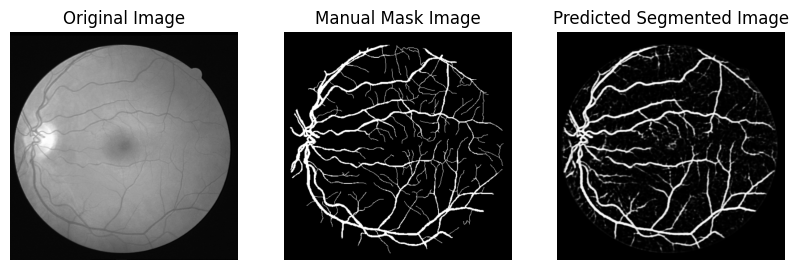

In [7]:
import os
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('retina_model_4_layer_advanced.h5')

# load the mask of the image
mask = load_img('Data/test/mask/10.png', color_mode='grayscale')

# Load an image for segmentation
image_path = 'Data/test/image/10.png'
image = load_img(image_path, color_mode='grayscale')
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0) / 255

# Perform segmentation
segmented_image = model.predict(image_array)[0]

# Post-process the segmented image as needed
# (e.g., thresholding, applying morphological operations)

# Display the original and segmented images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# manual mask image
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Manual Mask Image')
plt.axis('off')

# Predicted Segmented image
plt.subplot(1, 3, 3)
plt.imshow(segmented_image.squeeze(), cmap='gray')
plt.title('Predicted Segmented Image')
plt.axis('off')

plt.show()

------------------------Preprocessing-------------

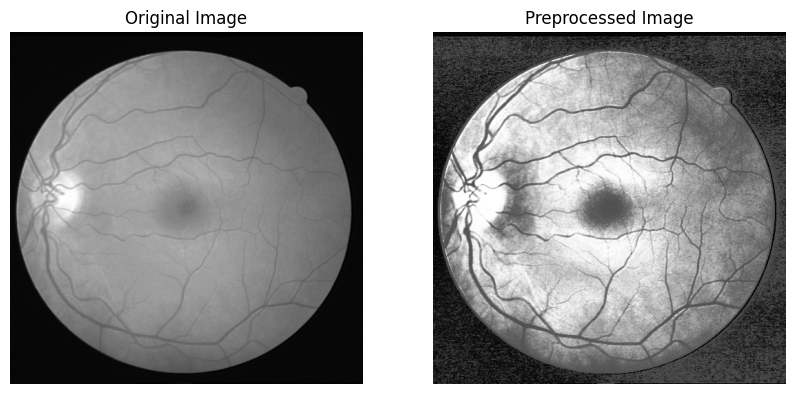

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def clahe_equalized(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(image)

def histo_equalized(image):
    return cv2.equalizeHist(image)

def preprocess_image(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply CLAHE equalization
    image = clahe_equalized(image)

    # Apply gamma adjustment
    image = adjust_gamma(image, gamma=1.2)

    # Apply histogram equalization
    image = histo_equalized(image)

    return image

# Path to the image
image_path = "Data/test/image/10.png"

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Plot the original and preprocessed images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.axis('off')

# Preprocessed Image
plt.subplot(1, 2, 2)
plt.title('Preprocessed Image')
plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')

plt.show()
